In [1]:
import warnings
import pandas as pd
from tqdm import tqdm

from helpers import classification as pf
from helpers import stats as bf
from helpers.file import save_file
from helpers.options import filtered_cols, selected_stats, strategy

from services import MySQLService

warnings.filterwarnings("ignore")

Setup Complete


In [ ]:
league = "allsvenskan"
start_season = 2014
save_pipeline = False

random_state = 0

min_games_played = 10
min_games_played_at = 5

betting_starts_after_n_games = 0

min_odds = 2.2
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

In [3]:
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 2640/2640 [00:00<00:00, 8863.00it/s]

Successfully generated teams ELOs.


,season,league,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,home_odds,away_odds,draw_odds,result,home_elo,away_elo
0,2014,allsvenskan,2014-03-30,1,Brommapojkarna,None,1,2,None,Kalmar,2.58,2.85,3.16,A,1500.00,1500.00
1,2014,allsvenskan,2014-03-30,1,Halmstad,None,1,2,None,Örebro,2.44,2.99,3.24,A,1500.00,1500.00
2,2014,allsvenskan,2014-03-30,1,Helsingborg,None,1,1,None,Djurgården,1.85,4.43,3.50,D,1500.00,1500.00
3,2014,allsvenskan,2014-03-30,1,Malmö,None,3,0,None,Falkenberg,1.26,11.92,5.77,H,1500.00,1500.00
4,2014,allsvenskan,2014-03-30,1,Mjällby,None,2,2,None,Gefle,1.96,4.07,3.34,D,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,2024,allsvenskan,2024-11-03,29,Brommapojkarna,None,0,1,None,Värnamo,3.02,2.20,3.57,A,1501.91,1531.16
2636,2024,allsvenskan,2024-11-03,29,Häcken,None,1,2,None,GAIS,1.86,3.50,4.15,A,1661.01,1556.25
2637,2024,allsvenskan,2024-11-03,29,Halmstad,None,1,0,None,Djurgården,4.11,1.88,3.49,H,1492.21,1644.44
2638,2024,allsvenskan,2024-11-03,29,Sirius,None,1,1,None,Mjällby,2.78,2.35,3.61,D,1598.71,1620.77


In [4]:
data_model = []

for index, game in tqdm(matches.iterrows(), total=len(matches)):
    if pd.isnull(game["home_odds"]):
        continue

    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict:
        continue

    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not away_stats_dict:
        continue

    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}

    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})

data_df = pd.DataFrame(data_model)

100%|██████████| 2640/2640 [00:36<00:00, 71.53it/s] 


In [5]:
display(data_df)

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_team,away_team,home_odds,away_odds,draw_odds,result,home_score,away_score,home_elo,away_elo
0,0.433333,0.300000,0.400000,0.300000,0.433333,0.3,0.4,0.3,0.600000,0.400000,...,Åtvidaberg,Halmstad,1.92,3.99,3.55,H,1,0,1491.90,1453.21
1,0.366667,0.300000,0.200000,0.500000,0.366667,0.3,0.2,0.5,0.400000,0.200000,...,Falkenberg,Häcken,3.19,2.26,3.37,D,1,1,1482.47,1547.21
2,0.566667,0.400000,0.500000,0.100000,0.566667,0.4,0.5,0.1,0.600000,0.200000,...,Göteborg,Norrköping,1.45,7.83,4.29,D,2,2,1536.50,1461.44
3,0.633333,0.500000,0.400000,0.100000,0.633333,0.5,0.4,0.1,0.400000,0.600000,...,Kalmar,Helsingborg,2.32,3.18,3.30,H,2,0,1541.56,1484.56
4,0.266667,0.100000,0.500000,0.400000,0.266667,0.1,0.5,0.4,0.200000,0.200000,...,Gefle,Djurgården,2.95,2.45,3.26,D,1,1,1477.61,1516.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,0.404762,0.285714,0.357143,0.357143,0.333333,0.2,0.4,0.4,0.285714,0.357143,...,Brommapojkarna,Värnamo,3.02,2.20,3.57,A,0,1,1501.91,1531.16
1697,0.500000,0.428571,0.214286,0.357143,0.400000,0.3,0.3,0.4,0.428571,0.214286,...,Häcken,GAIS,1.86,3.50,4.15,A,1,2,1661.01,1556.25
1698,0.357143,0.321429,0.107143,0.571429,0.300000,0.2,0.3,0.5,0.428571,0.142857,...,Halmstad,Djurgården,4.11,1.88,3.49,H,1,0,1492.21,1644.44
1699,0.476190,0.428571,0.142857,0.428571,0.433333,0.4,0.1,0.5,0.428571,0.142857,...,Sirius,Mjällby,2.78,2.35,3.61,D,1,1,1598.71,1620.77


In [10]:
from helpers.classification import simulate

last_season = matches.iloc[-1]["season"]

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
for season in tqdm(range(start_season + 1, last_season + 1)):
    matches, trained_models = pf.simulate(
        data_df,
        start_season,
        season,
        filtered_cols,
        betting_starts_after_n_games,
        strategy,
        verbose=1,
        random_state=0,
        preprocess=True,
        voting_classifier_models=["gradient_boosting", "mlp", "svm"]
    )

Training and evaluating models throughout the seasons...


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


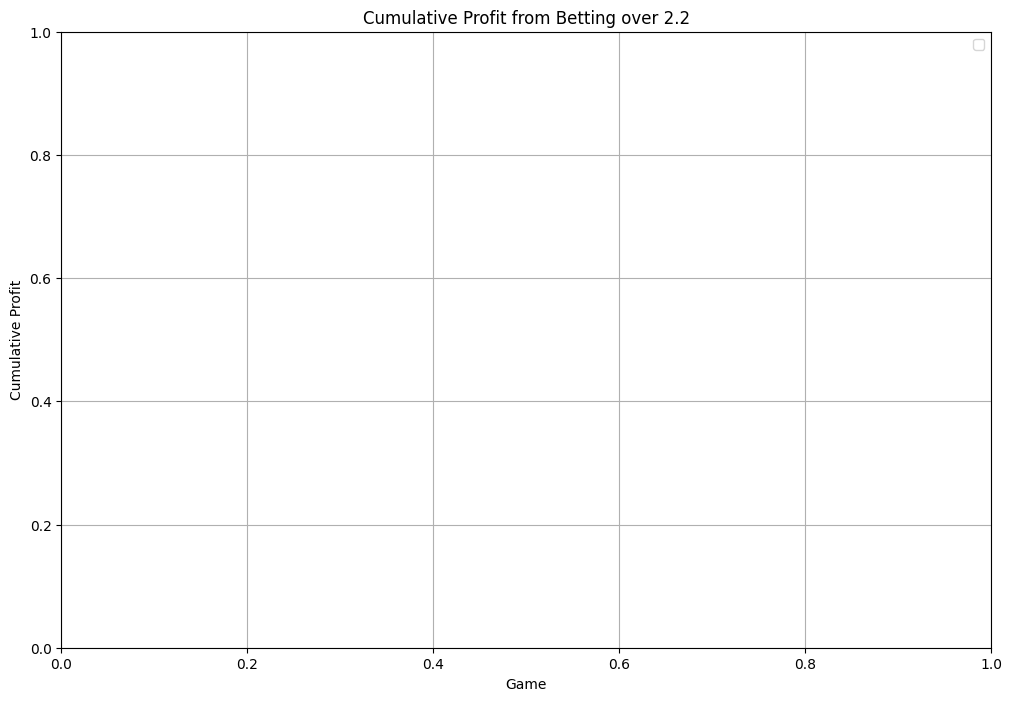

Home method (-123.34/766): -0.161
ML method with naive_bayes          --> (  -3.04/421): -0.0072
ML method with knn                  --> ( -33.23/498): -0.0667
ML method with logistic_regression  --> ( -12.77/431): -0.0296
ML method with svm                  --> (  -10.9/485): -0.0225
ML method with random_forest_default --> (  -3.57/429): -0.0083
ML method with random_forest        --> (  -7.37/409): -0.018
ML method with gradient_boosting    --> ( -11.47/443): -0.0259
ML method with ada_boost            --> ( -29.07/490): -0.0593
ML method with mlp                  --> ( -17.62/416): -0.0424
ML method with voting_classifier    --> (  -8.83/428): -0.0206

Profit for naive_bayes: $-3.04
Accuracy for naive_bayes: 0.49
Classification Report for naive_bayes:
              precision    recall  f1-score   support

           A       0.46      0.62      0.53       504
           D       0.29      0.16      0.20       385
           H       0.58      0.59      0.59       655

    accuracy    

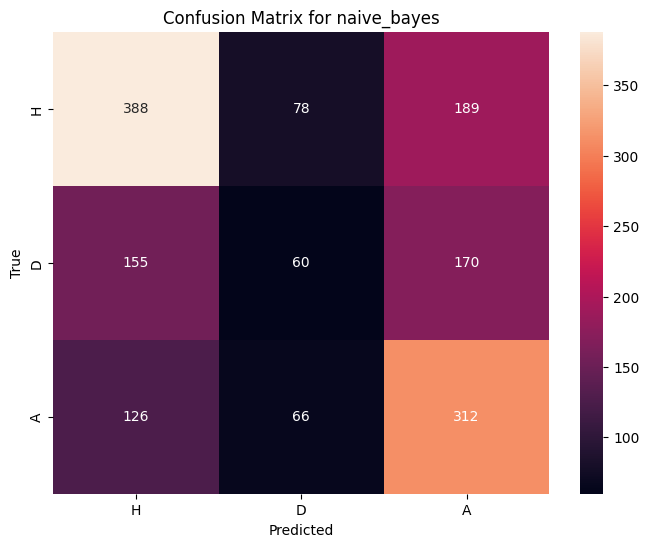

In [11]:
best_model_name = pf.get_simulation_results(matches, start_season, min_odds, plot_threshold, random_state, bankroll, strategy, default_value, default_bankroll_pct)

In [12]:
matches_filtered = matches[["date",  "season", "home_team", "away_team", "home_score", "away_score", "result", "home_odds", "draw_odds", "away_odds", f"PredictedRes_{best_model_name}", f'ProfitML_{best_model_name}', f'CumulativeProfitML_{best_model_name}']]
matches_filtered = matches_filtered[matches_filtered["season"] == 2024]
matches_filtered.tail(5)

# matches_filtered.to_csv("analysis_predictor.csv")

,date,season,home_team,away_team,home_score,away_score,result,home_odds,draw_odds,away_odds,PredictedRes_naive_bayes,ProfitML_naive_bayes,CumulativeProfitML_naive_bayes
1696,2024-11-03,2024,Brommapojkarna,Värnamo,0,1,A,3.02,3.57,2.20,D,0.0,-1.04
1697,2024-11-03,2024,Häcken,GAIS,1,2,A,1.86,4.15,3.50,D,0.0,-1.04
1698,2024-11-03,2024,Halmstad,Djurgården,1,0,H,4.11,3.49,1.88,A,0.0,-1.04
1699,2024-11-03,2024,Sirius,Mjällby,1,1,D,2.78,3.61,2.35,A,-1.0,-2.04
1700,2024-11-04,2024,Norrköping,AIK Stockholm,1,0,H,3.11,3.17,2.36,A,-1.0,-3.04


In [13]:
my_pipeline = trained_models[best_model_name]["pipeline"]
my_pipeline

data = {
    "pipeline": my_pipeline,
    "best_model_name": best_model_name,
    "min_games_played": min_games_played,
    "min_games_played_at": min_games_played_at,
    "min_odds": min_odds,
    "filtered_cols": filtered_cols,
    "strategy": strategy,
    "default_value": default_value,
    "default_bankroll_pct": default_bankroll_pct
}

# Save the pipeline
if save_pipeline:
    path = f"../dist/betting"
    
    save_file(path, data, league)